# Bayesian Linear Regression in Pystan

In [1]:
import multiprocessing
multiprocessing.set_start_method("fork")

# 1. Libraries

In [2]:
import pystan
import stan_utility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from scipy.stats import uniform, norm
import statsmodels.api as sm

INFO:matplotlib.font_manager:Generating new fontManager, this may take some time...


## 2. Simulated data

In [3]:
# Data
np.random.seed(1056)                                       # set seed to replicate example
nobs= 200                                                        # number of obs in model 

x1 = uniform.rvs(size=nobs)                             # random uniform variable
x2 = uniform.rvs(size=nobs)                             # second explanatory
x3 = uniform.rvs(size=nobs)     
X = np.column_stack((x1,x2,x3))                          # create response matrix
#X = sm.add_constant(X)                                   # add intercept

beta = [2.0, 3.0, -2.5]                                        # create vector of parameters
xb = np.dot(X, beta)                                         # linear predictor, xb

y = np.random.normal(loc=xb, scale=1.0, size=nobs)                      # create y as adjusted
# random normal variate

In [4]:
# Adds some names to our dataframe
df = pd.DataFrame(X)
df.columns = ["X1", 'X2', "X3"]

## 3. Model

In [5]:
model = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  matrix[N, K] x;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  real alpha;           // intercept
  vector[K] beta;       // coefficients for predictors
  real<lower=0> sigma;  // error scale
}
model {

  for (i in 1:K){beta[i] ~ normal(0, 1);} // priors

  y ~ normal(x * beta + alpha, sigma);  // likelihood

}
"""

In [6]:
model_dat = {
             'N': df.shape[0],
             'K': df.shape[1],
             'x': df,
             'y': y
             }

In [7]:
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_44f8a2a7e6b8e298002b8b758bff8b22 NOW.


In [8]:
fit = sm.sampling(data=model_dat, warmup=1000, iter=4000, chains=8)

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

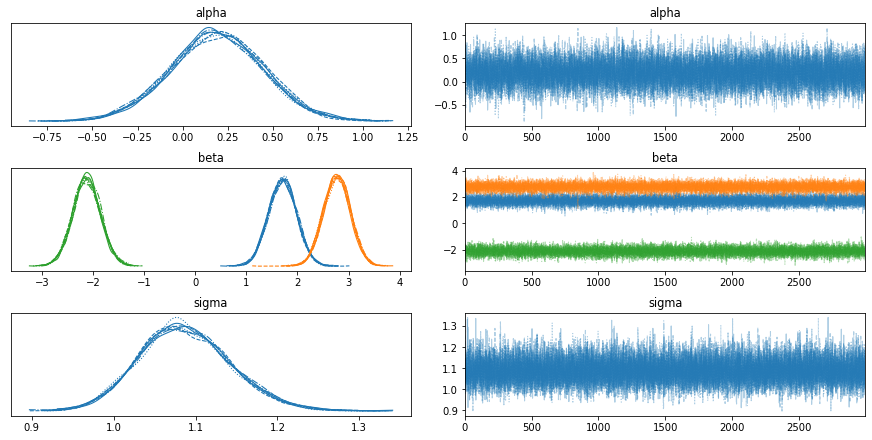

In [9]:
az.plot_trace(fit)

In [10]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.190,0.257,-0.313,0.660,0.002,0.002,12176.0,11217.0,12187.0,13306.0,1.0
beta[0],1.709,0.272,1.192,2.206,0.002,0.001,17435.0,17435.0,17446.0,16206.0,1.0
beta[1],2.773,0.262,2.272,3.246,0.002,0.001,17497.0,17497.0,17551.0,15230.0,1.0
beta[2],-2.126,0.270,-2.627,-1.610,0.002,0.001,17496.0,17496.0,17492.0,16730.0,1.0
sigma,1.087,0.056,0.988,1.198,0.000,0.000,21661.0,21408.0,21975.0,15473.0,1.0


In [11]:
display(fit)

Inference for Stan model: anon_model_44f8a2a7e6b8e298002b8b758bff8b22.
8 chains, each with iter=4000; warmup=1000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=24000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.19  2.3e-3   0.26  -0.32   0.02   0.19   0.36   0.69  12150    1.0
beta[1]   1.71  2.1e-3   0.27   1.18   1.53   1.71   1.89   2.24  17378    1.0
beta[2]   2.77  2.0e-3   0.26   2.26    2.6   2.77   2.95   3.28  17440    1.0
beta[3]  -2.13  2.0e-3   0.27  -2.66  -2.31  -2.13  -1.94  -1.59  17472    1.0
sigma     1.09  3.8e-4   0.06   0.98   1.05   1.08   1.12    1.2  21633    1.0
lp__    -123.5    0.02   1.61 -127.5 -124.4 -123.2 -122.3 -121.4   9731    1.0

Samples were drawn using NUTS at Sat Feb  6 00:41:47 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

## Checks with stan_utility

In [14]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 24000 iterations ended with a divergence (0.0%)
0 of 24000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


<AxesSubplot:>

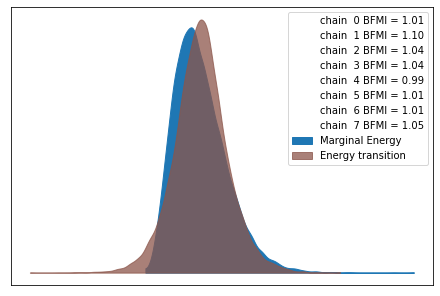

In [15]:
inf_data = az.convert_to_inference_data(fit)
az.plot_energy(inf_data)

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n1'}>],
       [<AxesSubplot:title={'center':'beta\n2'}>,
        <AxesSubplot:title={'center':'sigma'}>, <AxesSubplot:>]],
      dtype=object)

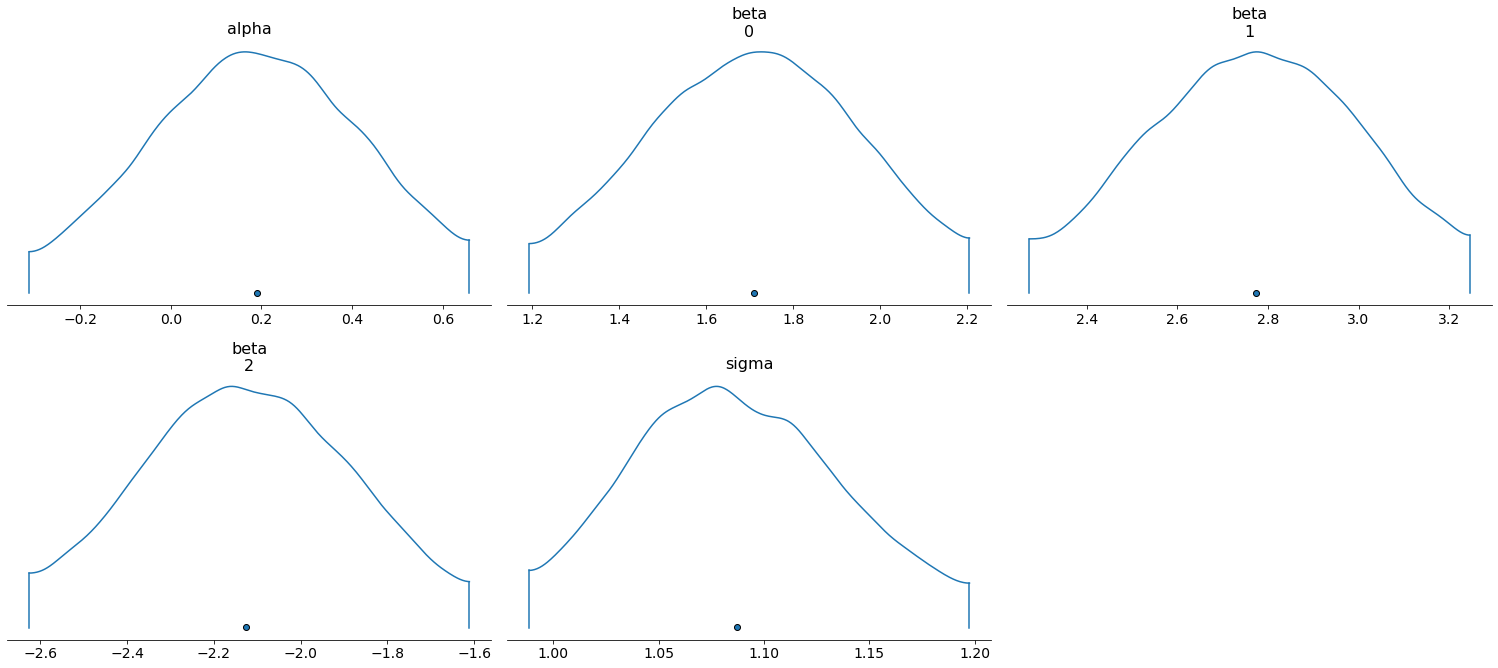

In [16]:
az.plot_density(inf_data)


In [17]:
print(fit)

Inference for Stan model: anon_model_44f8a2a7e6b8e298002b8b758bff8b22.
8 chains, each with iter=4000; warmup=1000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=24000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.19  2.3e-3   0.26  -0.32   0.02   0.19   0.36   0.69  12150    1.0
beta[1]   1.71  2.1e-3   0.27   1.18   1.53   1.71   1.89   2.24  17378    1.0
beta[2]   2.77  2.0e-3   0.26   2.26    2.6   2.77   2.95   3.28  17440    1.0
beta[3]  -2.13  2.0e-3   0.27  -2.66  -2.31  -2.13  -1.94  -1.59  17472    1.0
sigma     1.09  3.8e-4   0.06   0.98   1.05   1.08   1.12    1.2  21633    1.0
lp__    -123.5    0.02   1.61 -127.5 -124.4 -123.2 -122.3 -121.4   9731    1.0

Samples were drawn using NUTS at Sat Feb  6 00:41:47 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [18]:
fit

Inference for Stan model: anon_model_44f8a2a7e6b8e298002b8b758bff8b22.
8 chains, each with iter=4000; warmup=1000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=24000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.19  2.3e-3   0.26  -0.32   0.02   0.19   0.36   0.69  12150    1.0
beta[1]   1.71  2.1e-3   0.27   1.18   1.53   1.71   1.89   2.24  17378    1.0
beta[2]   2.77  2.0e-3   0.26   2.26    2.6   2.77   2.95   3.28  17440    1.0
beta[3]  -2.13  2.0e-3   0.27  -2.66  -2.31  -2.13  -1.94  -1.59  17472    1.0
sigma     1.09  3.8e-4   0.06   0.98   1.05   1.08   1.12    1.2  21633    1.0
lp__    -123.5    0.02   1.61 -127.5 -124.4 -123.2 -122.3 -121.4   9731    1.0

Samples were drawn using NUTS at Sat Feb  6 00:41:47 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [19]:
import statsmodels.api as smapi

In [20]:
df1=smapi.add_constant(df)

In [21]:
l_model = smapi.OLS(y,df1)

In [22]:
results =l_model.fit()
results.params

const    0.106156
X1       1.822373
X2       2.976165
X3      -2.286558
dtype: float64

In [23]:
results.tvalues

const     0.409484
X1        6.477885
X2       11.202847
X3       -8.331521
dtype: float64

In [24]:
results.rsquared

0.5555327973553876

In [25]:
def mi_lm(df, x_col, y_col, adds_constant="Yes"):
    "reporting r**2"
    import statsmodels.api as sm
    x, y = df[x_col], df[y_col]

    if adds_constant=="Yes":
        x = sm.add_constant(x)

    results = sm.OLS(y,x)

    return results.fit().rsquared


In [26]:
mi_lm(df,"X1","X3","No")

0.576260804362569